# Linear LLM-innovator evolution chain

This notebook showcases a simple example run of linear evolution with a LLM-innovator on the kernel density estimation (KDE) challenge problem. 


### Table of contents
1. [Run LLM-innovation loop](#loop)
2. [Visualise KDE instances](#visualise)

In [12]:
import os
import traceback
import time

import numpy as np

import matplotlib.pyplot as plt


# challenge
import src
import run_challenge_instance


# local env
from dotenv import load_dotenv, find_dotenv

env_name = '.env'
load_dotenv(find_dotenv(env_name))

NANOGPT_APIKEY = os.getenv("NANOGPT_APIKEY")


# past nanoGPT API call data
import json

with open('nanoGPT_models.json', 'r') as f:
    a = json.load(f)
    
model_names = [aa['id'] for aa in a['data']]

<a id="loop"></a>
## 1. Run LLM-innovation loop

1748416539454

In [21]:
run_seed = 123
LLM_temperature = 1.0
LLM_name = "chatgpt-4o-latest"#"auto-model-basic"#"deepseek-r1-nano"#
max_prompt_iters = 64
LLM_prompt_time_ms = int(time.time() * 1000)  # ms, include as we don't have seed control of LLM API

challenge_params = {
    'dims': 2, 
    'num_train_pts': 2 ** 8, 
    'num_test_pts': 2 ** 5, 
}


# experiment name
exp_name = 'KDE'
folder_name = f'seed{run_seed}iters{max_prompt_iters}time{LLM_prompt_time_ms}'

# local package
import sys
sys.path.append(f'{exp_name}/')
import template


dir_path = f'{exp_name}/{folder_name}/'
os.makedirs(dir_path, exist_ok=True)

logger = src.logger.setup_logger(logger_name='linear_evolution', logger_filename=None)

In [3]:
system_prompt = run_challenge_instance.build_system_prompt(
    template.algorithm_prompt, template.feedback_prompt, template.first_algorithm)
print(system_prompt)

EvaluateAlgorithm, ConstructFeedback = src.utils.import_model_specific_symbols(
    exp_name + '/template.py', ['EvaluateAlgorithm', 'ConstructFeedback'])


Code up an algorithm in Python 3 with the following goals and specifications: 
Write a function that takes in training data points of shape (num_pts, D) and spits out a D-dimensional Gaussian mixture model through parameters: component weight logits of shape (num_comps,), component means (num_comps, D) and component covariances (num_comps, D, D). 
You are implementing kernel density estimation using some form of bandwidth selection heuristic for your base kernel of choice.
Use only NumPy and implement the rest from scratch.

I will run your algorithm on a set of problem instances and report back to you: 
Target score to maximize is your test likelihoods on a fixed set of problem instances (different datasets, here we test on 64 instances), we provide both per instance likelihoods and a single average over instances. In addition, you will get:
- Train data likelihoods (per instance and averaged)
- Time to run evaluation for all instances (we want this to be as low as possible, but prio

In [4]:
api = src.llm.OpenAIAPI(provider="nanogpt")
api.set_api_key(NANOGPT_APIKEY)

model = src.llm.BaseLLM(LLM_name, LLM_temperature)
model.set_api(api)
model.set_system_prompt(system_prompt)

In [5]:
logger.info("Generating initial seed algorithm...")

dir_path = f'{exp_name}/{folder_name}/'
os.makedirs(dir_path, exist_ok=True)


algo_id = 1
with open(dir_path + f'algo{algo_id}.py', 'w') as f:
    f.write(template.first_algorithm)

try:
    eval_results = EvaluateAlgorithm(run_seed, challenge_params, dir_path + f'algo{algo_id}.py')
    try:
        feedback_prompt = ConstructFeedback(eval_results)
    except Exception as err:
        error_str = traceback.format_exc()
        feedback_prompt = 'ConstructFeedback error: ' + str(err) + "\nTraceback: " + error_str

except Exception as err:
    error_str = traceback.format_exc()
    feedback_prompt = 'EvaluateAlgorithms error: ' + str(err) + "\nTraceback: " + error_str

feedback_prompt_list = [feedback_prompt]

logger.info(f"Sending algorithm {algo_id} prompt...")
receive_status, receive_message = model.send_prompt(feedback_prompt)
if receive_status:
    pycode = receive_message.split('<python>')[1].split('</python>')[0]
    reasontext = receive_message.split('<reasoning>')[1].split('</reasoning>')[0]

    pycode_list = [pycode]
    reasontext_list = [reasontext]
    
else:
    logger.error(receive_status)
    raise ValueError(receive_status)




logger.info("Starting LLM-innovation evolution loop...")

invalid_response_retry = False
for algo_id in range(2, max_prompt_iters + 1):

    if invalid_response_retry is False:
        with open(dir_path + f'algo{algo_id}.py', 'w') as f:
            f.write(pycode)
        
        try:
            eval_results = EvaluateAlgorithm(run_seed, challenge_params, dir_path + f'algo{algo_id}.py')
            try:
                feedback_prompt = ConstructFeedback(eval_results)
            except Exception as err:
                error_str = traceback.format_exc()
                feedback_prompt = 'ConstructFeedback error: ' + str(err) + "\nTraceback: " + error_str

        except Exception as err:
            error_str = traceback.format_exc()
            feedback_prompt = 'EvaluateAlgorithms error: ' + str(err) + "\nTraceback: " + error_str

    feedback_prompt_list.append(feedback_prompt)
    
    logger.info(f"Sending algorithm {algo_id} prompt...")
    receive_status, receive_message = model.send_prompt(feedback_prompt)
    if receive_status:
        try:
            pycode = receive_message.split('<python>')[1].split('</python>')[0]
            reasontext = receive_message.split('<reasoning>')[1].split('</reasoning>')[0]

            pycode_list.append(pycode)
            reasontext_list.append(reasontext)
            invalid_response_retry = False

        except Exception as err:
            feedback_prompt = 'Response formatting error: ' + str(err)
            pycode_list.append(None)
            reasontext_list.append(None)
            invalid_response_retry = True
            algo_id -= 1  # retry at same algorithm index
        
    else:
        logger.error(receive_status)
        raise ValueError(receive_status)



2025-05-28 08:00:43 - linear_evolution - INFO - Generating initial seed algorithm...
2025-05-28 08:00:43 - linear_evolution - INFO - Sending algorithm 1 prompt...
2025-05-28 08:00:53 - linear_evolution - INFO - Starting LLM-innovation evolution loop...
2025-05-28 08:00:54 - linear_evolution - INFO - Sending algorithm 2 prompt...
2025-05-28 08:01:05 - linear_evolution - INFO - Sending algorithm 3 prompt...
2025-05-28 08:01:16 - linear_evolution - INFO - Sending algorithm 4 prompt...
2025-05-28 08:01:25 - linear_evolution - INFO - Sending algorithm 5 prompt...
2025-05-28 08:01:40 - linear_evolution - INFO - Sending algorithm 6 prompt...
2025-05-28 08:01:50 - linear_evolution - INFO - Sending algorithm 7 prompt...
2025-05-28 08:02:03 - linear_evolution - INFO - Sending algorithm 8 prompt...
2025-05-28 08:02:15 - linear_evolution - INFO - Sending algorithm 9 prompt...


In [11]:
print(reasontext_list[0])


I swapped the bandwidth selection heuristic from Silverman's rule to Scott's rule. Scott's adjusts the scaling with respect to the dimensionality of the training data, which may improve the Gaussian kernel density estimation results for higher-dimensional or more complex datasets. This adjustment should enhance the log-likelihood scores particularly for test instances while keeping the implementation compact and simple. No significant complexity is added in terms of runtime or code.



In [7]:
feedback_prompt_list

["{'test_log_likelihood_average': -0.11464502721877785, 'test_log_likelihood_per_instance': [0.9436957238600858, -0.4729494464713748, -0.2264429370384461, -0.7007776283900593, -0.9232754844612989, -0.003964355120345597, 1.0284470761520372, 1.8512561972270205, -0.29732861945171696, -1.8150773973397716, 0.6692385920786403, -1.9387457737623535, -0.8671204662647813, 1.4761400714697217, -1.5102239297320539, -0.27301640852685416, -1.5818094616971514, -1.7505340951086379, -1.6090573020163634, 0.16267944187649053, -0.7349897831147569, 1.2576291415801018, 2.2009111647161763, -0.6185100605089426, 0.29744888515907314, -1.6616526997425745, -1.6472710276715459, -1.4815521273246022, -0.8949180734617177, -0.04304038424744597, 0.9207291097727401, 0.12081180627892345, -1.5445964318784213, 1.7112150918282487, -0.5359830033584655, 0.28973397310944315, 0.08217859778652384, 0.4887187567459343, -0.603386482381782, -1.4540160651448728, -0.9251284436010294, -1.2194721849178334, 0.7739318314558823, 0.944511611

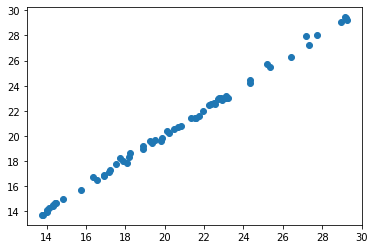

In [12]:
plt.scatter(eval_results['test_log_likelihood'], eval_results['train_log_likelihood'])

<a id="visualise"></a>
## 2. Visualise KDE instances

In [ ]:
seed = 1234
rng_params = np.random.default_rng(seed)
rng_samps = np.random.default_rng(seed + 1)

num_samples = 2 ** 20
z = rng_samps.normal(size=(num_samples, 1))

x = template.generate_samples(rng_params, z)

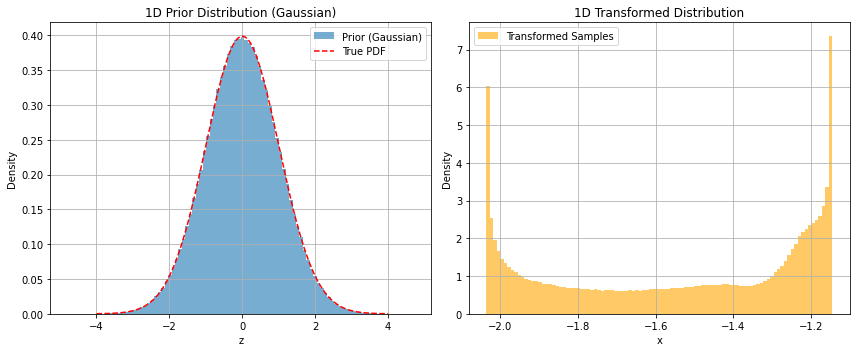

In [ ]:
# Plot
plt.figure(figsize=(12, 5))

# Prior
plt.subplot(1, 2, 1)
plt.hist(z, bins=100, density=True, alpha=0.6, label="Prior (Gaussian)")
x_vals = np.linspace(-4, 4, 200)
plt.plot(x_vals, norm.pdf(x_vals), 'r--', label="True PDF")
plt.title("1D Prior Distribution (Gaussian)")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Transformed
plt.subplot(1, 2, 2)
plt.hist(x, bins=100, density=True, alpha=0.6, label="Transformed Samples", color="orange")
plt.title("1D Transformed Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
seed = 12349
rng_params = np.random.default_rng(seed)
rng_samps = np.random.default_rng(seed + 1)

num_samples = 2 ** 20
z = rng_samps.normal(size=(num_samples, 2))

x = template.generate_samples(rng_params, z)

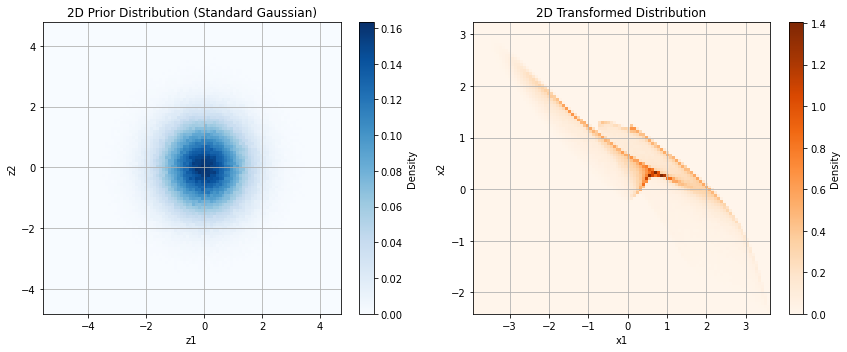

In [23]:
# Plot
plt.figure(figsize=(12, 5))

# Prior
plt.subplot(1, 2, 1)
plt.hist2d(z[:, 0], z[:, 1], bins=100, density=True, cmap='Blues')
plt.colorbar(label="Density")
plt.title("2D Prior Distribution (Standard Gaussian)")
plt.xlabel("z1")
plt.ylabel("z2")
#plt.axis("equal")
plt.grid(True)

# Transformed
plt.subplot(1, 2, 2)
plt.hist2d(x[:, 0], x[:, 1], bins=100, density=True, cmap='Oranges')
plt.colorbar(label="Density")
plt.title("2D Transformed Distribution")
plt.xlabel("x1")
plt.ylabel("x2")
#plt.axis("equal")
plt.grid(True)

plt.tight_layout()
plt.show()

In [70]:
dims = challenge_params['dims']
instances_seed = run_seed
algo_id = 9
algo_script_file = dir_path + f'algo{algo_id}.py'



# generate instance
algorithm_func, = src.utils.import_model_specific_symbols(algo_script_file, ['algorithm_func'])

# evaluation
num_instances = 64
start_time = time.time()

grid_pts = 128


plot_data = []
for i in range(8):
    print(f'{i + 1} / {num_instances}')

    seed = instances_seed + i

    rng_samps = np.random.default_rng(seed + 1)

    num_samples = challenge_params['num_train_pts']
    z = rng_samps.normal(size=(num_samples, dims))
    rng_params = np.random.default_rng(seed)
    train_xs = template.generate_samples(rng_params, z)

    num_samples = challenge_params['num_test_pts']
    z = rng_samps.normal(size=(num_samples, dims))
    rng_params = np.random.default_rng(seed)
    test_xs = template.generate_samples(rng_params, z)

    weight_logits, mus, covs = algorithm_func(train_xs)
    ws_logits_batch, mus_batch, covs_batch = weight_logits[None], mus[None], covs[None]

    # evaluate GMM log prob
    x = np.linspace(train_xs[:, 0].min() - 0.5, train_xs[:, 0].max() + 0.5, grid_pts)
    y = np.linspace(train_xs[:, 1].min() - 0.5, train_xs[:, 1].max() + 0.5, grid_pts)
    X, Y = np.meshgrid(x, y)
    xy = np.stack([X, Y], axis=-1).reshape(-1, 2)  # (num_pts, 2)
    log_prob_xy = template.log_prob_multivariate_Gaussian_mixture(xy, ws_logits_batch, mus_batch, covs_batch)


    plot_data.append(
        [train_xs, test_xs, X, Y, log_prob_xy.reshape(grid_pts, grid_pts)]
    )

1 / 64
2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64


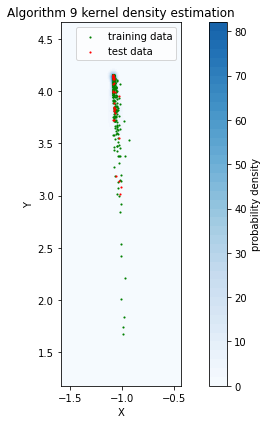

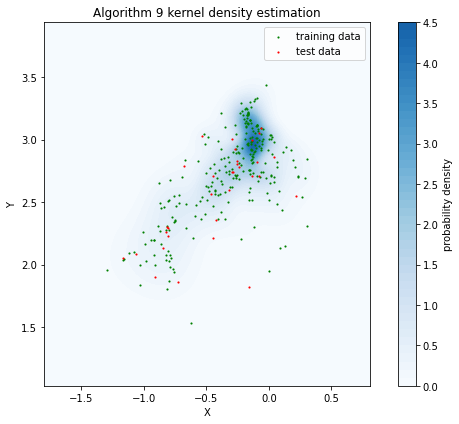

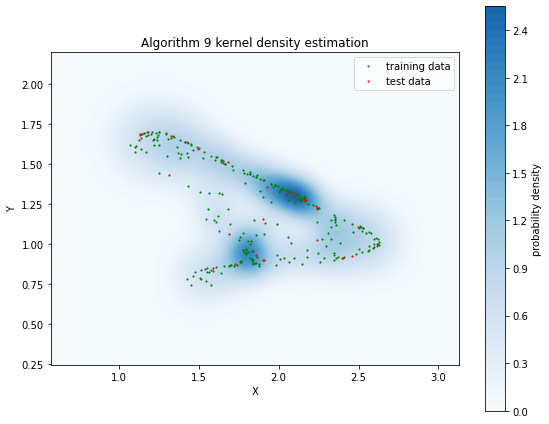

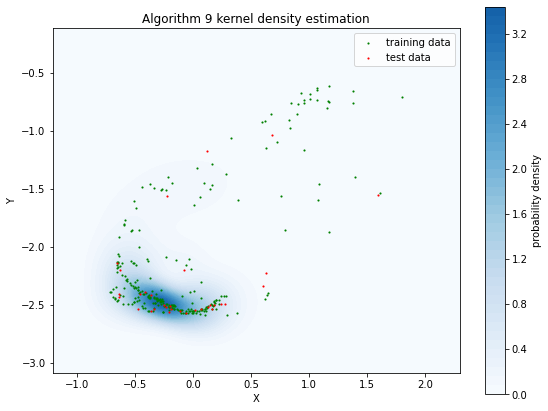

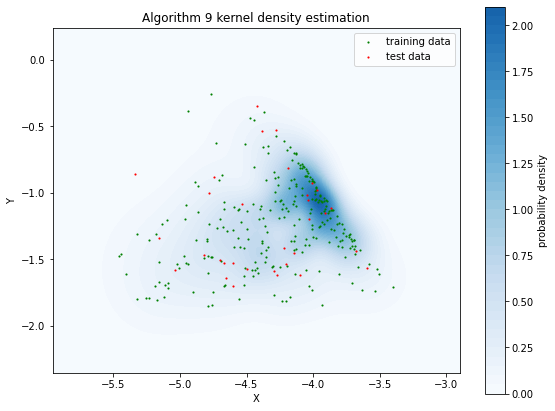

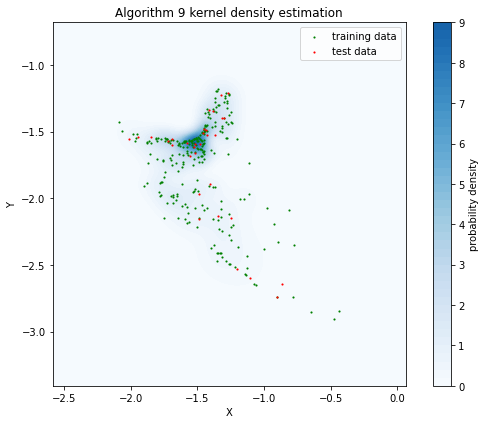

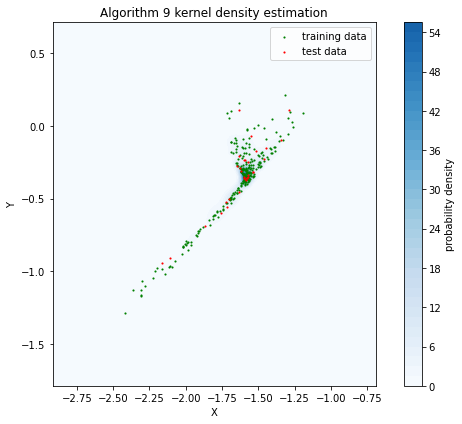

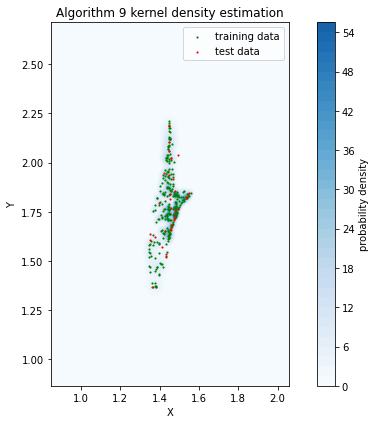

In [78]:
for ind in range(8):

    train_xs, test_xs, X, Y, log_prob_xy = plot_data[ind]
    P = np.exp(log_prob_xy)

    plt.figure(figsize=(8, 6))

    plt.contourf(X, Y, P, vmax=P.max() * 1.25, levels=50, cmap="Blues")
    plt.colorbar(label="probability density")

    plt.scatter(train_xs[:, 0], train_xs[:, 1], marker='.', s=5, c='green', label='training data')
    plt.scatter(test_xs[:, 0], test_xs[:, 1], marker='.', s=5, c='red', label='test data')

    plt.title(f"Algorithm {algo_id} kernel density estimation")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().set_aspect('equal')

    plt.legend()
    plt.tight_layout()
    plt.show()